# Building trees from line list of HIV infections simulated with a branching process

This notebook shows how to generate trees based on the line lists output by the HIV branching process simulator. The trees are generated using functions in IDM's `phylomodels` library, and are formatted as `ETE3` objects.

We first load the set of packages that allow us to run the simulator:

In [1]:
# Standard packages
import os
import numpy as np
import pandas as pd

%matplotlib inline

# R-related packages
import rpy2
import rpy2.robjects as robjects
r = robjects.r

from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# We may need to install some packages
try:
    from rpy2.robjects.packages import importr
    dplyr = importr('dplyr')
except RRuntimeError:
    from rpy2.robjects.packages import importr, data
    utils = importr('utils')
    base = importr('base')
    utils.chooseCRANmirror()
    utils.install_packages('dplyr')

# Set up working directory
cwd = os.getcwd()
os.chdir('../')

In [2]:
r.source('hiv_branching_process.R')

... running simulation with parameters:
      samplesize =  100
      timestep   =  1
      sim_time   =  375
      seed       =  0
      mean_partner_parameter =  0.45
      acts_per_day_parameter =  0.3
      lambda_parameter       =  0.002
      removal_rate_parameter =  0.001
      sampling_delay         =  365
... simulation step  10 /  375
... simulation step  20 /  375
... simulation step  30 /  375
... simulation step  40 /  375
... simulation step  50 /  375
... simulation step  60 /  375
... simulation step  70 /  375
... simulation step  80 /  375
... simulation step  90 /  375
... simulation step  100 /  375
... simulation step  110 /  375
... simulation step  120 /  375
... simulation step  130 /  375
... simulation step  140 /  375
... simulation step  150 /  375
... simulation step  160 /  375
... simulation step  170 /  375
... simulation step  180 /  375
... simulation step  190 /  375
... simulation step  200 /  375
... simulation step  210 /  375
... simulation step 

value,[RTYPES.VECSXP]
visible,[RTYPES.LGLSXP]


Now we can configure and run the simulator. Once we do that, we can convert the R objects returned by `simulate_transmission` into pandas dataframes. In particular, we are interested in the `population_summary` dataframe, which is the linelist that will be used for building the transmission trees.

In [3]:
out = r.simulate_transmission( sim_time=365*10 )
population_summary_r  = out.rx2('population_summary' )
transmission_record_r = out.rx2('transmission_record')

with localconverter( robjects.default_converter + pandas2ri.converter ):
    population_summary  = robjects.conversion.rpy2py( population_summary_r  )
    transmission_record = robjects.conversion.rpy2py( transmission_record_r )

... running simulation with parameters:
      samplesize =  100
      timestep   =  1
      sim_time   =  3650
      seed       =  0
      mean_partner_parameter =  0.5
      acts_per_day_parameter =  0.3
      lambda_parameter       =  0.002
      removal_rate_parameter =  0.001
      sampling_delay         =  365
... simulation step  10 /  3650
... simulation step  20 /  3650
... simulation step  30 /  3650
... simulation step  40 /  3650
... simulation step  50 /  3650
... simulation step  60 /  3650
... simulation step  70 /  3650
... simulation step  80 /  3650
... simulation step  90 /  3650
... simulation step  100 /  3650
... simulation step  110 /  3650
... simulation step  120 /  3650
... simulation step  130 /  3650
... simulation step  140 /  3650
... simulation step  150 /  3650
... simulation step  160 /  3650
... simulation step  170 /  3650
... simulation step  180 /  3650
... simulation step  190 /  3650
... simulation step  200 /  3650
... simulation step  210 /  3650

In [4]:
population_summary.head()

,recipient,removal_rate,partners,acts_per_day,transmission_risk_per_act,transmission_risk_per_day,source,infectionTime,sampleTime,cumulative_partners,cumulative_transmissions
1,1.0,0.001,0,0.152823,0.001549,0.000000,0.0,0.0,365.0,0.0,0.0
2,2.0,0.001,1,0.072246,0.001522,0.000110,0.0,0.0,365.0,0.0,0.0
3,3.0,0.001,0,0.522873,0.002059,0.000000,0.0,0.0,365.0,0.0,0.0
4,4.0,0.001,2,0.854449,0.001926,0.003289,0.0,0.0,684.0,0.0,2.0
5,5.0,0.001,0,0.577191,0.001668,0.000000,0.0,0.0,365.0,0.0,0.0


We can now build the trees and work with them as we would work with any `ETE3` tree object: we can draw the tree, save it as a newick file, sample it, etc.

In [5]:
from phylomodels.trees import generate_treeFromFile

In [6]:
population_summary['recipient'] = population_summary['recipient'].astype(int).astype(str)
population_summary['source'] = population_summary['source'].astype(int).astype(str)

In [7]:
# Let's get rid of seed infections that didn't produce other infections
all_src = population_summary['source'].unique()
population_summary = population_summary[ population_summary['recipient'].isin(all_src) ]

In [8]:
trees = generate_treeFromFile.read_treeFromLineList( population_summary,
                                                     ID = 'recipient',
                                                     infectorID = 'source',
                                                     infectTime = 'infectionTime',
                                                     sampleTime = 'sampleTime',
                                                     features = ['partners', 'acts_per_day', 'transmission_risk_per_act', 'removal_rate']
                                                   )

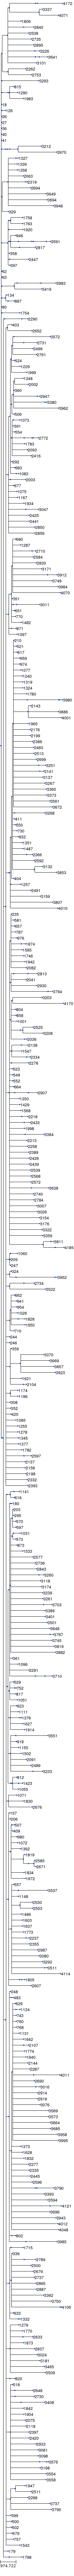

In [9]:
trees[0].render('%%inline')